In [5]:
import logging
logging.basicConfig(level=logging.INFO)

import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import numpy as np

import os

import matplotlib.pyplot as plt
import seaborn as sns
import tqdm


In [13]:
tqdm.tqdm_pandas(tqdm.tqdm_notebook())

In [9]:
%cd ..

/Users/isajosep/Code/Repos/Synthego


In [11]:
import sequence_parser

The provided CSV file ”synthesis data.csv” contains simulated data of 10 syntheses for several different custom sequences. This data is a smaller, simplified version of the data that the data science team at -- regularly collects. The data includes information about the quantity of material, overall quality, and time it took to process. These are the columns in the CSV:

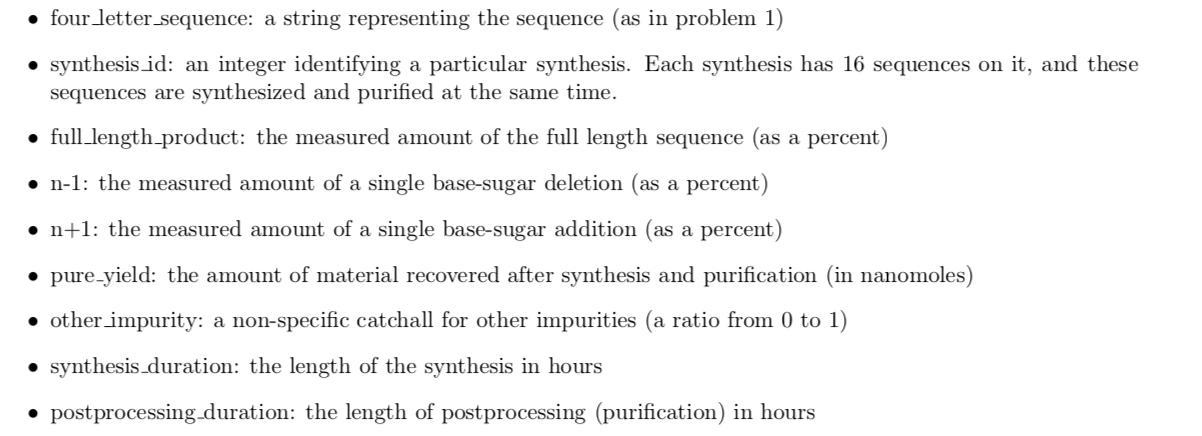

In [6]:
synth_data = pd.read_csv('/Users/isajosep/Data/Misc/synthesis_data.csv')

In [7]:
synth_data.sample(3)

,four_letter_sequence,synthesis_id,n-1,n+1,pure_yield,full_length_product,other_impurity,synthesis_duration,postprocessing_duration
57,-Cro-Gro-Aro-Aro-Uro-Aro-Uro-Gro-Aro-Uro-Cro-C...,4,8.589517,7.935955,2.397462,69.192073,0.014349,61.546239,60.160847
66,-Gro-Aro-Cro-Gro-Cro-Aro-Uro-Aro-Aro-Aro-Gro-A...,5,7.350241,9.868113,8.129809,72.076463,0.419470,56.237046,108.421597
71,-Aro-Cro-Aro-Aro-Aro-Gro-Uro-Cro-Aro-Cro-Aro-U...,5,4.886914,7.307557,4.952300,74.985244,0.582099,56.237046,108.421597


In [25]:
synth_data.shape

(160, 11)

# Annotate

## Length

In [18]:
synth_data['sequence_length'] = synth_data.progress_apply(lambda row: sequence_parser.sequence_str_to_len(row['four_letter_sequence']), axis=1)

In [23]:
synth_data.sequence_length.value_counts()

100    112
36      48
Name: sequence_length, dtype: int64

## Type

In [21]:
synth_data['product_type'] = synth_data.progress_apply(lambda row: sequence_parser.sequence_str_to_product_type(row['four_letter_sequence']), axis=1)

In [22]:
synth_data.product_type.value_counts()

mod RNA        64
vanilla RNA    48
chimera        48
Name: product_type, dtype: int64

# Pure Yield investigation

Basic idea: 

1. one-hot encode categorical variable `synthesis_id` and `product_type`, 
2. clean
3. standardize, 
4. some minimal feature engineering for intuitive domain-based transforms, 
5. then use a model to predict `synthesis_yield`, starting wtih simple ones. Assess based on train/test split.    

## One-hot Encode

In [24]:
import sklearn.preprocessing

### `synthesis_id`

In [ ]:
sklearn.preprocessing.OneHotEncoder()

In [30]:
ohe = sklearn.preprocessing.OneHotEncoder(sparse=False)

In [33]:
ohe_fit = ohe.fit(synth_data.synthesis_id.values.reshape(-1,1))

In [53]:
one_hot_encoded_id = pd.DataFrame(ohe_fit.transform(synth_data.synthesis_id.values.reshape(-1,1)), index=synth_data.index, columns=["synthesis {}".format(i) for i in ohe_fit.active_features_])

In [55]:
synth_data_enc = synth_data.drop('synthesis_id', axis=1).join(one_hot_encoded_id)

In [56]:
synth_data_enc.sample(3)

,four_letter_sequence,n-1,n+1,pure_yield,full_length_product,other_impurity,synthesis_duration,postprocessing_duration,sequence_length,product_type,synthesis 1,synthesis 2,synthesis 3,synthesis 4,synthesis 5,synthesis 6,synthesis 7,synthesis 8,synthesis 9,synthesis 10
67,-Gro-Aro-Cro-Gro-Cro-Aro-Uro-Aro-Aro-Aro-Gro-A...,5.594045,6.535247,6.226543,70.580353,0.262782,56.237046,108.421597,100,vanilla RNA,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
121,-Uro-Uro-Cro-Cdo-Tdo-Cdo-Gdo-Ado-Gdo-Gdo-Aro-G...,NaN,NaN,-0.088024,NaN,NaN,22.262647,61.099977,36,chimera,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
58,-Gro-Cro-Aro-Gro-Cro-Cro-Cro-Uro-Cro-Cro-Aro-C...,5.266225,12.650897,0.970612,74.583233,0.000000,61.546239,60.160847,100,vanilla RNA,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


###  `product_type`

In [57]:
le = sklearn.preprocessing.LabelEncoder()

In [64]:
ohe_pt = sklearn.preprocessing.OneHotEncoder(sparse=False)

In [78]:
le_fit = le.fit(synth_data_enc.product_type.values.reshape(-1,1))

/Users/isajosep/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [81]:
le_fit.classes_

array(['chimera', 'mod RNA', 'vanilla RNA'], dtype=object)

In [83]:
ohe_pt_fit = ohe_pt.fit(le_fit.transform(synth_data_enc.product_type).reshape(-1,1))

In [89]:
ohe_pt_df = pd.DataFrame(ohe_pt_fit.transform(le_fit.transform(synth_data_enc.product_type).reshape(-1,1)), columns=le_fit.classes_, index=synth_data_enc.index)

In [97]:
synth_data_enc_both = ohe_pt_df.join(synth_data_enc.drop('product_type', axis=1))

In [98]:
synth_data_enc_both.sample(3)

,chimera,mod RNA,vanilla RNA,four_letter_sequence,n-1,n+1,pure_yield,full_length_product,other_impurity,synthesis_duration,postprocessing_duration,sequence_length,synthesis 1,synthesis 2,synthesis 3,synthesis 4,synthesis 5,synthesis 6,synthesis 7,synthesis 8,synthesis 9,synthesis 10
41,0.0,1.0,0.0,-Gms-Ums-Ams-Uro-Aro-Uro-Aro-Gro-Aro-Uro-Gro-A...,NaN,NaN,NaN,NaN,NaN,12.239413,0.013144,100,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
153,0.0,1.0,0.0,-Gms-Ums-Ams-Uro-Aro-Uro-Aro-Gro-Aro-Uro-Gro-A...,8.273984,6.049915,7.637061,70.800504,0.0,54.708102,54.518116,100,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
157,0.0,1.0,0.0,-Gms-Ums-Cms-Gro-Cro-Uro-Cro-Cro-Cro-Cro-Gro-G...,2.875343,8.890667,6.105651,74.955671,0.0,54.708102,54.518116,100,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
